# Constraint Satisfaction Problems - Backtracking and Forward Checking

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import networkx as nx
from copy import deepcopy
from typing import List, Dict, Any, Tuple

Install `networkx` to display the map visualizations: 
```
conda install networkx
```

## CSP: Map Coloring

As we know from the [Four Color Theorem](http://en.wikipedia.org/wiki/Four_color_theorem) any division of a plane into contiguous regions can be colored such that no two adjacent regions are the same color by using only four colors.

From the book, we know that we can translate this problem into a CSP where the map is represented as a [planar graph](http://en.wikipedia.org/wiki/Planar_graph) and the goal is to color all the nodes such that no adjacent nodes are colored the same color.

Countries will be represented as follows:

In [2]:
connecticut = { "nodes": ["Fairfield", "Litchfield", "New Haven", "Hartford", "Middlesex", "Tolland", "New London", "Windham"],
                "edges": [(0,1), (0,2), (1,2), (1,3), (2,3), (2,4), (3,4), (3,5), (3,6), (4,6), (5,6), (5,7), (6,7)],
                "coordinates": [( 46, 52), ( 65,142), (104, 77), (123,142), (147, 85), (162,140), (197, 94), (217,146)]}
print(connecticut)

{'nodes': ['Fairfield', 'Litchfield', 'New Haven', 'Hartford', 'Middlesex', 'Tolland', 'New London', 'Windham'], 'edges': [(0, 1), (0, 2), (1, 2), (1, 3), (2, 3), (2, 4), (3, 4), (3, 5), (3, 6), (4, 6), (5, 6), (5, 7), (6, 7)], 'coordinates': [(46, 52), (65, 142), (104, 77), (123, 142), (147, 85), (162, 140), (197, 94), (217, 146)]}


The helper function, `draw_map`, takes the planar_map, a figure size in abstract units, and a List of color assignments in the same order as the nodes in the planar_map. A default value for `color_assignments` is provided, `None`, that simply colors all the nodes red. Otherwise, `color_assignments` must be a `List of Tuples` where each `Tuple` is a node name and assigned color. The order of `color_assignments` must be the same as the order of `"nodes"` in the `planar_map`.

In [3]:
# function by S. Butcher, 2022
def draw_map(name, planar_map, size, color_assignments=None):
    def as_dictionary(a_list):
        dct = {}
        for i, e in enumerate(a_list):
            dct[i] = e
        return dct
    
    G = nx.Graph()
    
    labels = as_dictionary(planar_map["nodes"])
    pos = as_dictionary(planar_map["coordinates"])
    
    # create a List of Nodes as indices to match the "edges" entry.
    nodes = [n for n in range(0, len(planar_map["nodes"]))]

    if color_assignments:
        colors = [c for n, c in color_assignments]
    else:
        colors = ['red' for c in range(0,len(planar_map[ "nodes"]))]

    G.add_nodes_from(nodes)
    G.add_edges_from(planar_map[ "edges"])

    plt.figure(figsize=size, dpi=100)
    plt.title(name)
    nx.draw(G, node_color = colors, with_labels = True, labels = labels, pos = pos)
    
#    plt.savefig(name + ".png")

Using this function, we can draw `connecticut`:

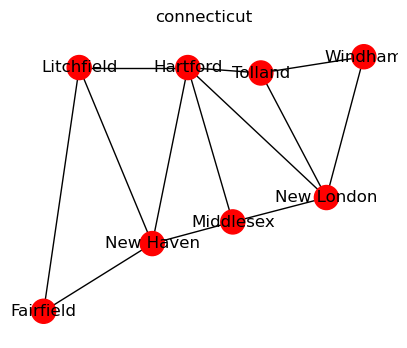

In [4]:
draw_map("connecticut", connecticut, (5,4), [(n, "red") for n in connecticut["nodes"]])

(Previous description and helpers function by S. Butcher, 2022)

The goal of the subsequent cells is to **implement** the **Backtracking and Forward Checking** algorithm to collor the maps of `connecticut` *and* `europe`.

<a id="get_constraints_map"></a>
## get_constraints_map

*The get_constraints_map function takes the constraints list of the form [(0, 1), (0, 2)], representing that node 0 shares constraints with nodes 1 and 2. The function converts the constraints to a dictionary for quicker constraint checking in the subsequent lookups.* **Used by**: [color_map](#color_map)

* **constraint_list** List[Tuple]: a list of constraints of the form [(0, 1), (0, 2)], representing that node 0 shares constraints with nodes 1 and 2

**returns** Dict[int, List[int]]

In [5]:
def get_constraints_map(constraint_list: List[Tuple]) -> Dict[int, List[int]]:
    constraints = {}
    for value in constraint_list:
        if value[0] not in constraints.keys():
            constraints[value[0]] = [value[1]]
        else:
            constraints[value[0]].append(value[1])

        if value[1] not in constraints.keys():
            constraints[value[1]] = [value[0]]
        else:
            constraints[value[1]].append(value[0])
    return constraints

In [6]:
#assertions/unit tests
test_constraints_1 = [(0, 1), (2, 0), (0, 3), (3, 1)]
expected_map_1 = {
    0: [1, 2, 3],
    1: [0, 3],
    2: [0],
    3: [0, 1]
    }

assert get_constraints_map(test_constraints_1) == expected_map_1

# the following example should set a constraint for both 0 and 1 because the graph 
# constraints are bi-directional
test_constraints_2 = [(0, 1)]
expected_map_2 = {
    0: [1],
    1: [0],
    }

assert get_constraints_map(test_constraints_2) == expected_map_2

test_constraints_3 = []
expected_map_3 = {}

assert get_constraints_map(test_constraints_3) == expected_map_3

<a id="maybe_print_trace"></a>
## maybe_print_trace

*The maybe_print_trace function prints the provided message if trace is set to True and does not print anything if trace is set to False* **Used by**: [backtrack_search](#backtrack_search), [minimum_remaining_values](#minimum_remaining_values), [least_constrained_values](#least_constrained_values)

* **message** str: the string to print
* **trace**  bool: a boolean specifying if the function should print the trace

**returns** None

In [7]:
def maybe_print_trace(message: str, trace: bool) -> None:
    if trace == True:
        print(message)

In [8]:
# assertions/unit tests
# There are no unit tests for the print function.
# The calls below show that the function prints when trace is true and does not print otherwise.
maybe_print_trace("Should print this message", True)
maybe_print_trace("Should not print this message", False)

Should print this message


<a id="is_complete"></a>
## is_complete

*The is_complete function returns True if all values in the current state have assignments and False otherwise.* **Used by**: [backtrack_search](#backtrack_search)

* **current_state** Dict[str, Any]: a dictionary tracking the current state for forward checking of the form {"node_name":{"domain": {"red": None, "blue": "other_node_name"}, "assignment": None}. The colors in the domain have the possible values None or "node_name" where node_name is the node that eliminated the value from the domain.

**returns** bool

In [9]:
def is_complete(current_state: Dict[str, Any]) -> bool:
    return all(value["assignment"] != None for value in current_state.values())

In [10]:
#assertions and unit test
test_state_1 = {"node_1": {"assignment": "blue"}, "node_2": {"assignment": None}}
assert is_complete(test_state_1) == False

test_state_2 = {"node_1": {"assignment": "blue"}, "node_2": {"assignment": "green"}}
assert is_complete(test_state_2) == True

test_state_3 = {"node_1": {"assignment": None}}
assert is_complete(test_state_1) == False

<a id="is_consistent"></a>
## is_consistent

*The is_consistent function returns True if the current assignment satisfies all problem constraints and returns False otherwise.* **Used by**: [backtrack_search](#backtrack_search)

* **nodes** List[str]: a list of nodes in the map
* **current_state** Dict[str, Any]: a dictionary tracking the current state for forward checking of the form {"node_name":{"domain": {"red": None, "blue": "other_node_name"}, "assignment": None}. The colors in the domain have the possible values None or "node_name" where node_name is the node that eliminated the value from the domain.
* **value** str: the current value (color) under consideration
* **constraints** Dict[int, List[int]]: a dictionary of node:[constraints] mappings
* **var_index** int: the index of the current variable (location) under consideration
  
**returns** bool

In [11]:
def is_consistent(nodes: List[str], current_state: Dict[str, Any], value: str, constraints: Dict[int, List[int]], var_index: int) -> bool:
    var_constraints = constraints[var_index]
    for constraint in var_constraints:
        constraint_assignment = current_state[nodes[constraint]]["assignment"]
        if constraint_assignment == value:
            return False
    return True

In [12]:
#assertions/unit tests
test_nodes = ["0", "1", "2", "3"]
test_state = {"0": {"assignment": "blue"}, "1": {"assignment": None}, "2": {"assignment": "green"}, "3": {"assignment": None}}
constraints = {
    0: [1, 2, 3],
    1: [0, 2],
    2: [0, 1],
    3: [0]
}

# check that the assignment "red" to "1" is consistent
assert is_consistent(test_nodes, test_state, "red", constraints, 1) == True
# check that the assignment "green" to "1" is not consistent
assert is_consistent(test_nodes, test_state, "green", constraints, 1) == False
# check that the assignment "green" to "3" is consistent becuase it only shares
# a constraint with "0"
assert is_consistent(test_nodes, test_state, "green", constraints, 3) == True

<a id="format_assignments"></a>
## format_assignments

*The format_assignment function retrieves all assignments from the current state and returns a list of tuples of the form [(variable, value)] in the original order of the nodes in the planar map.* **Used by**: [backtrack_search](#backtrack_search)

* **nodes** List[str]: a list of nodes in the planar map
* **current_state** Dict[str, Any]: a dictionary tracking the current state for forward checking of the form {"node_name":{"domain": {"red": None, "blue": "other_node_name"}, "assignment": None}. The colors in the domain have the possible values None or "node_name" where node_name is the node that eliminated the value from the domain.
  
**returns** List[Tuple]

In [13]:
def format_assignments(nodes: List[str], current_state: Dict[str, Any]) -> List[Tuple]:
    final_assignments = []
    for node in nodes:
        final_assignments.append((node, current_state[node]["assignment"]))
    return final_assignments

In [14]:
# assertions/unit tests 
test_nodes = ["0", "1", "2", "3"]
test_state = {"0": {"assignment": "blue"}, "1": {"assignment": "red"}, "2": {"assignment": "green"}, "3": {"assignment": "red"}}

assert format_assignments(test_nodes, test_state) == [("0", "blue"), ("1", "red"), ("2", "green"), ("3", "red")]

test_nodes_2 = ["3", "1", "2", "0"]
assert format_assignments(test_nodes_2, test_state) == [("3", "red"), ("1", "red"), ("2", "green"), ("0", "blue")]

test_nodes_3 = ["0"]
test_state_3 = {"0": {"assignment": "blue"}}
assert format_assignments(test_nodes_3, test_state_3) == [("0", "blue")]

# test empty dataframes
assert format_assignments([], {}) == []

<a id="minimum_remaining_values"></a>
## minimum_remaining_values

*The minimum_remaining_values function applies the Minimum Remaining Values heuristic for variable selection. This heuristic prioritizes the node with the fewest remaining values available.* **Used by**: [backtrack_search](#backtrack_search)

* **num_options** int: the maximum number of options
* **current_state** Dict[str, Any]: a dictionary tracking the current state for forward checking of the form {"node_name":{"domain": {"red": None, "blue": "other_node_name"}, "assignment": None}. The colors in the domain have the possible values None or "node_name" where node_name is the node that eliminated the value from the domain.
* **trace** bool: a boolean specifying if the algorithm should log debug statements to trace the actions
    
**returns** str

In [15]:
def minimum_remaining_values(num_options: int, current_state: Dict[str, Any], trace: bool) -> str:
    min_remaining = num_options
    min_remaining_selections = []

    for key, value in current_state.items():
        if value["assignment"] == None:
            available_selections = 0
            for selection, status in value["domain"].items():
                if status == None:
                    available_selections += 1
            if available_selections < min_remaining:
                min_remaining = available_selections
                min_remaining_selections = [key]
            # Add ties to the list
            elif available_selections == min_remaining:
                min_remaining_selections.append(key)
    # sort ties in ascending (alphabetical) order
    min_remaining_selections = sorted(min_remaining_selections)
    maybe_print_trace(f"DEBUG: The variables with the minimum remaining values are {min_remaining_selections} with {min_remaining} values.", trace)
    return min_remaining_selections[0]

In [16]:
# assertions/unit tests
test_state_1 = {
    "0": {"domain": {"red": None, "green": "1", "blue": None}, "assignment": None}, 
    "1": {"domain": {"red": None, "green": "1", "blue": None}, "assignment": "green"}, 
    "2": {"domain": {"red": None, "green": None, "blue": None}, "assignment": None},
    "3": {"domain": {"red": None, "green": None, "blue": None}, "assignment": None}
    }

# standard case
assert minimum_remaining_values(3, test_state_1, False) == "0"

test_state_2 = {
    "0": {"domain": {"red": None, "green": "1", "blue": None}, "assignment": None}, 
    "1": {"domain": {"red": "3", "green": "1", "blue": None}, "assignment": "green"}, 
    "2": {"domain": {"red": None, "green": None, "blue": None}, "assignment": None},
    "3": {"domain": {"red": None, "green": None, "blue": None}, "assignment": None}
    }

# green has the fewest values, but it is already assigned, so choose "0"
assert minimum_remaining_values(3, test_state_2, False) == "0"

test_state_2 = {
    "0": {"domain": {"red": None, "green": "1", "blue": None}, "assignment": None}, 
    "1": {"domain": {"red": "3", "green": "1", "blue": None}, "assignment": "green"}, 
    "2": {"domain": {"red": None, "green": "1", "blue": None}, "assignment": None},
    "3": {"domain": {"red": None, "green": None, "blue": None}, "assignment": None}
    }

# there is a tie, break it in ascending order
assert minimum_remaining_values(3, test_state_2, False) == "0"

<a id="get_num_constraints"></a>
## get_num_constraints

*The get_num_constraints function returns the number of constraining variables that share the provided value. The function does not count variables that are already assigned. The function does not increment the number of constraints if forward elimination has eliminated the value for the constraint domain.* **Used by**: [least_constrained_values](#least_constrained_values)

* **nodes** List[str]: the nodes list from the planar map
* **value** str: the value (color) under consideration
* **current_state** Dict[str, Any]: a dictionary tracking the current state for forward checking of the form {"node_name":{"domain": {"red": None, "blue": "other_node_name"}, "assignment": None}. The colors in the domain have the possible values None or "node_name" where node_name is the node that eliminated the value from the domain.
* **constraints** Dict[int, List[int]]: a dictionary where the keys are the variables and the values are a list of constraints for that variable
* **var** str: the variable (location) under consideration

**returns** int

In [17]:
def get_num_constraints(nodes: List[str], value: str, current_state: Dict[str, Any], constraints: Dict[int, List[int]], var: str) -> int:
    num_constraints = 0
    var_index = nodes.index(var)
    var_constraints = constraints[var_index]
    for constraint in var_constraints:
        constraint_assignment = current_state[nodes[constraint]]["assignment"]
        constraint_domain = current_state[nodes[constraint]]["domain"]
        # if the value is in the constraint domain and the constraint is undefined
        if value in constraint_domain and constraint_assignment == None:
            # if the value has not been eliminated for the constraint domain, increment
            if current_state[nodes[constraint]]["domain"][value] == None:
                num_constraints +=1
    return num_constraints

In [18]:
# assertions/unit tests
test_nodes = ["0", "1", "2", "3"]
test_state = {"0": {"domain": {"red": None, "blue": None, "green": None}, "assignment": "blue"}, 
              "1": {"domain": {"red": None, "blue": None, "green": None}, "assignment": None}, 
              "2": {"domain": {"red": None, "blue": None, "green": None}, "assignment": None}, 
              "3": {"domain": {"red": None, "blue": None, "green": None}, "assignment": None}}

constraints_1 = {
    0: [1, 2, 3],
    1: [0, 2],
    2: [0, 1],
    3: [0]}

# Should not count "0" because it is assigned, and should not count "3" because it is not a constaint of "2"
assert get_num_constraints(test_nodes, "green", test_state, constraints_1, "2") == 1

# "0" is the only constraint, but it is already assigned
assert get_num_constraints(test_nodes, "green", test_state, constraints_1, "3") == 0

test_state_2 = {"0": {"domain": {"red": None, "blue": None, "green": None}, "assignment": "green"}, 
                "1": {"domain": {"red": None, "blue": None, "green": "0"}, "assignment": None}, 
                "2": {"domain": {"red": None, "blue": None, "green": None}, "assignment": None}, 
                "3": {"domain": {"red": None, "blue": None, "green": None}, "assignment": None}}

constraints_2 = {
    0: [1, 3],
    1: [0, 2],
    2: [1],
    3: [0]}

# 1 is the only constraint, but the value "green" has been eliminated from "1"'s domain by node "0"
assert get_num_constraints(test_nodes, "green", test_state_2, constraints_2, "2") == 0

<a id="least_constrained_values"></a>
## least_constrained_values

*The least_constrained_values function returns the domain of available moves for a variable ordered using the Least Constraining Values heuristic. This heuristic prioritizes the values that remove the minimum number of values from constraint domains.* **Used by**: [backtrack_search](#backtrack_search)

* **nodes** List[str]: the nodes list from the planar map
* **constraints** Dict[int, List[int]]: a dictionary where the keys are the variables and the values are a list of constraints for that variable
* **current_state** Dict[str, Any]: a dictionary tracking the current state for forward checking of the form {"node_name":{"domain": {"red": None, "blue": "other_node_name"}, "assignment": None}. The colors in the domain have the possible values None or "node_name" where node_name is the node that eliminated the value from the domain.
* **var** str: the variable (location) under consideration
* **trace** bool: a boolean specifying if the algorithm should log debug statements to trace the actions

**returns** List[str]

In [19]:
def least_constrained_values(nodes: List[str], constraints: Dict[int, List[int]], current_state: Dict[str, Any], var: str, trace: bool) -> List[str]:
    value_constraints = {}
    
    for color, value in current_state[var]["domain"].items():
        # confirm that the value has not been eliminated from the domain
        if value == None:
            val_constraints = get_num_constraints(nodes, color, current_state, constraints, var)
            value_constraints[color] = val_constraints
    # sort colors by values and in ascending order to break ties
    least_constrained_values = [item[0] for item in sorted(value_constraints.items(), key=lambda x: (x[1], x[0]))]

    maybe_print_trace(f"DEBUG: The values ordered by least constraints are {least_constrained_values}.", trace)   
    return least_constrained_values

In [20]:
# assertions/unit tests
test_nodes = ["0", "1", "2", "3"]
test_state = {"0": {"domain": {"red": None, "blue": None, "green": None}, "assignment": None}, 
              "1": {"domain": {"red": None, "blue": None, "green": None}, "assignment": None}, 
              "2": {"domain": {"red": None, "blue": None, "green": None}, "assignment": None}, 
              "3": {"domain": {"red": None, "blue": None, "green": None}, "assignment": None}}

constraints_1 = {
    0: [1, 2, 3],
    1: [0, 2],
    2: [0, 1],
    3: [0]}

# confirm that the function sorts in ascending (alphabetical order if there are ties
assert least_constrained_values(test_nodes, constraints_1, test_state, "2", False) == ["blue", "green", "red"]

test_state_2 = {"0": {"domain": {"red": None, "blue": None, "green": None}, "assignment": "blue"}, 
                "1": {"domain": {"red": None, "blue": "1", "green": None}, "assignment": None}, 
                "2": {"domain": {"red": None, "blue": "1", "green": None}, "assignment": None}, 
                "3": {"domain": {"red": None, "blue": "1", "green": "4"}, "assignment": None}}

constraints_2 = {
    0: [1, 2, 3],
    1: [0, 2, 3],
    2: [0, 1, 3],
    3: [0, 1, 2]}

# confirm that the function prioritizes least constraining values if no ties
# the state shows that node "3" had the value for green eliminated and noe "1" is already assigned
# "green" has one constraint and "red" has 2 constraints. "blue" is not in the domain because it has
# been eliminated by node "1"
assert least_constrained_values(test_nodes, constraints_2, test_state_2, "2", False) == ["green", "red"]

# node "3" should only have one more available in it's domain, return "red"
assert least_constrained_values(test_nodes, constraints_2, test_state_2, "3", False) == ["red"]

<a id="forward_check"></a>
## forward_check

*The forward_check function updates the current state to remove the current value selection from constraint domains. The function sets the domain value to the node that removed the value from this domain. This implementation of forward checking would also support the backjumping algorithm with no modifications to this function. The backtracking algorithm backtracks to the last seen node. Whereas the backjumping algorithm backtracks to the node that removed the last available move from a constraint domain. The function returns the updated state.* **Used by**: [backtrack_search](#backtrack_search)

* **nodes** List[str]: the nodes list from the planar map
* **current_state** Dict[str, Any]: a dictionary tracking the current state for forward checking of the form {"node_name":{"domain": {"red": None, "blue": "other_node_name"}, "assignment": None}. The colors in the domain have the possible values None or "node_name" where node_name is the node that eliminated the value from the domain.
* **constraints** Dict[int, List[int]]: a dictionary where the keys are the variables and the values are a list of constraints for that variable
* **var_index** int: the index of the variable (location) under consideration
* **value** str: the value selection that should be eliminated from constraint domains

**returns** Dict[str, Any]

In [21]:
def forward_check(nodes: List[str], current_state: Dict[str, Any], constraints: Dict[int, List[int]], var_index: int, value: str) -> Dict[str, Any]:
    var_constraints = constraints[var_index]
    for constraint in var_constraints:
        constraint_var = nodes[constraint]
        # update the value to reflect the node that removed the value from
        # the domain
        constraint_domain = deepcopy(current_state[constraint_var]["domain"])
        # check if more than one constraint took this value
        if constraint_domain[value] == None:
            constraint_domain[value] = [nodes[var_index]]
        else:
            constraint_domain[value].append(nodes[var_index])
        current_state[constraint_var]["domain"] = constraint_domain
    return current_state

In [22]:
# assertions/ unit tests
test_nodes = ["0", "1", "2", "3"]
test_state = {"0": {"domain": {"red": None, "blue": None, "green": None}, "assignment": None}, 
              "1": {"domain": {"red": None, "blue": None, "green": None}, "assignment": None}, 
              "2": {"domain": {"red": None, "blue": None, "green": None}, "assignment": None}, 
              "3": {"domain": {"red": None, "blue": None, "green": None}, "assignment": None}}

constraints_1 = {
    0: [1, 2, 3],
    1: [0, 2],
    2: [0, 1],
    3: [0]}

test_state["0"]["assignment"] = "red"

expected_state_1 = {"0": {"domain": {"red": None, "blue": None, "green": None}, "assignment": "red"}, 
                    "1": {"domain": {"red": ["0"], "blue": None, "green": None}, "assignment": None}, 
                    "2": {"domain": {"red": ["0"], "blue": None, "green": None}, "assignment": None}, 
                    "3": {"domain": {"red": ["0"], "blue": None, "green": None}, "assignment": None}}

assert forward_check(test_nodes, test_state, constraints_1, 0, "red") == expected_state_1

expected_state_1["1"]["assignment"] = "blue"

expected_state_2 = {"0": {"domain": {"red": None, "blue": ["1"], "green": None}, "assignment": "red"}, 
                    "1": {"domain": {"red": ["0"], "blue": None, "green": None}, "assignment": "blue"}, 
                    "2": {"domain": {"red": ["0"], "blue": ["1"], "green": None}, "assignment": None}, 
                    "3": {"domain": {"red": ["0"], "blue": None, "green": None}, "assignment": None}}

assert forward_check(test_nodes, expected_state_1, constraints_1, 1, "blue") == expected_state_2

expected_state_2["2"]["assignment"] = "green"

expected_state_3 = {"0": {"domain": {"red": None, "blue": ["1"], "green": ["2"]}, "assignment": "red"}, 
                    "1": {"domain": {"red": ["0"], "blue": None, "green": ["2"]}, "assignment": "blue"}, 
                    "2": {"domain": {"red": ["0"], "blue": ["1"], "green": None}, "assignment": "green"}, 
                    "3": {"domain": {"red": ["0"], "blue": None, "green": None}, "assignment": None}}

assert forward_check(test_nodes, expected_state_2, constraints_1, 2, "green") == expected_state_3

expected_state_3["3"]["assignment"] = "blue"

expected_state_4 = {"0": {"domain": {"red": None, "blue": ["1", "3"], "green": ["2"]}, "assignment": "red"}, 
                    "1": {"domain": {"red": ["0"], "blue": None, "green": ["2"]}, "assignment": "blue"}, 
                    "2": {"domain": {"red": ["0"], "blue": ["1"], "green": None}, "assignment": "green"}, 
                    "3": {"domain": {"red": ["0"], "blue": None, "green": None}, "assignment": "blue"}}

assert forward_check(test_nodes, expected_state_3, constraints_1, 3, "blue") == expected_state_4

<a id="backtrack_updates"></a>
## backtrack_updates

*The backtrack_updates function resets the values eliminated with forward_checking each time the algorithm needs to backtrack. The function returns the updated state.* **Used by**: [backtrack_search](#backtrack_search)

* **nodes** List[str]: the nodes list from the planar map
* **current_state** Dict[str, Any]: a dictionary tracking the current state for forward checking of the form {"node_name":{"domain": {"red": None, "blue": "other_node_name"}, "assignment": None}. The colors in the domain have the possible values None or "node_name" where node_name is the node that eliminated the value from the domain.
* **constraints** Dict[int, List[int]]: a dictionary where the keys are the variables and the values are a list of constraints for that variable
* **var_index** int: the index of the variable (location) under consideration
* **value** str: the value selection that should be eliminated from constraint domains

**returns** Dict[str, Any]

In [23]:
def backtrack_updates(nodes: List[str], current_state: Dict[str, Any], constraints: Dict[int, List[int]], var_index: int, value: str) -> Dict[str, Any]:
    var_constraints = constraints[var_index]
    for constraint in var_constraints:
        constraint_var = nodes[constraint]
        # update the color value to reflect the node that removed the color from
        # the constraint domain
        constraint_domain = deepcopy(current_state[constraint_var]["domain"])
        if constraint_domain[value] != None:
            if len(constraint_domain[value]) == 1:
                constraint_domain[value] = None
            else:
                constraint_domain[value].remove(nodes[var_index])
            current_state[constraint_var]["domain"] = constraint_domain
    # Update node assignment
    current_state[nodes[var_index]]["assignment"] = None
    return current_state

In [24]:
# assertions/unit tests
test_nodes = ["0", "1", "2", "3"]
test_state = {"0": {"domain": {"red": None, "blue": ["1", "3"], "green": ["2"]}, "assignment": "red"}, 
              "1": {"domain": {"red": ["0"], "blue": None, "green": ["2"]}, "assignment": "blue"}, 
              "2": {"domain": {"red": ["0"], "blue": ["1"], "green": None}, "assignment": "green"}, 
              "3": {"domain": {"red": ["0"], "blue": None, "green": None}, "assignment": "blue"}}

constraints_1 = {
    0: [1, 2, 3],
    1: [0, 2],
    2: [0, 1],
    3: [0]}

expected_state_1 = {"0": {"domain": {"red": None, "blue": ["1"], "green": ["2"]}, "assignment": "red"}, 
                    "1": {"domain": {"red": ["0"], "blue": None, "green": ["2"]}, "assignment": "blue"}, 
                    "2": {"domain": {"red": ["0"], "blue": ["1"], "green": None}, "assignment": "green"}, 
                    "3": {"domain": {"red": ["0"], "blue": None, "green": None}, "assignment": None}}

assert backtrack_updates(test_nodes, test_state, constraints_1, 3, "blue") == expected_state_1

expected_state_2 = {"0": {"domain": {"red": None, "blue": ['1'], "green": None}, "assignment": "red"}, 
                    "1": {"domain": {"red": ['0'], "blue": None, "green": None}, "assignment": "blue"}, 
                    "2": {"domain": {"red": ['0'], "blue": ['1'], "green": None}, "assignment": None}, 
                    "3": {"domain": {"red": ['0'], "blue": None, "green": None}, "assignment": None}}


assert backtrack_updates(test_nodes, expected_state_1, constraints_1, 2, "green") == expected_state_2

expected_state_3 = {"0": {"domain": {"red": None, "blue": None, "green": None}, "assignment": "red"}, 
                    "1": {"domain": {"red": ['0'], "blue": None, "green": None}, "assignment": None}, 
                    "2": {"domain": {"red": ['0'], "blue": None, "green": None}, "assignment": None}, 
                    "3": {"domain": {"red": ['0'], "blue": None, "green": None}, "assignment": None}}


assert backtrack_updates(test_nodes, expected_state_2, constraints_1, 1, "blue") == expected_state_3

<a id="backtrack_search"></a>
## backtrack_search

*The backtrack_search function applies backtracking and forward checking (BT+FC) to solve constraint satisfaction problems. The algorithm assigns values to variables based on the heuristic functions used for variable and value selections. This implementation used the Minimum Remaining Values heuristic for variable selection and the Least Constraining Value heuristic for value selection. Forward-checking eliminates values from constraint domains with each selection. The algorithm applies backtracking if it reaches a variable with an empty domain, meaning that no values are available after constraint value assignments. The algorithm returns a list of tuples containing (Variable, Value) assignments.* **Used by**: [color_map](#color_map)

* **planar_map** Dict[str, Any]: the planar map containing the nodes list, constraints, and coordinates.
* **current_state** Dict[str, Any]: a dictionary tracking the current state for forward checking of the form {"node_name":{"domain": {"red": None, "blue": "other_node_name"}, "assignment": None}. The colors in the domain have the possible values None or "node_name" where node_name is the node that eliminated the value from the domain.
* **constraints** Dict[int, List[int]]: a dictionary where the keys are the variables and the values are a list of constraints for that variable
* **num_colors** int: the number of colors available for map coloring
* **trace** bool: a boolean specifying if the algorithm should log debug statements to trace the actions

**returns** List[Tuple] | None

In [25]:
def backtrack_search(planar_map: Dict[str, Any], current_state: Dict[str, Any], constraints: Dict[int, List[int]], num_colors: int, trace: bool) -> List[Tuple] | None:
    if is_complete(current_state):
        return format_assignments(planar_map["nodes"], current_state)
    var = minimum_remaining_values(num_colors, current_state, trace)
    values = least_constrained_values(planar_map["nodes"], constraints, current_state, var, trace)
    
    for value in values:
        var_index = planar_map["nodes"].index(var)
        if is_consistent(planar_map["nodes"], current_state, value, constraints, var_index):
            maybe_print_trace(f"ASSIGNING value {value} to node {var}.", trace)
            current_state[var]["assignment"] = value
            current_state = forward_check(planar_map["nodes"], current_state, constraints, var_index, value)
            result = backtrack_search(planar_map, current_state, constraints, num_colors, trace)
            if result != None:
                return result
            # backtrack if recursive checks failed
            maybe_print_trace(f"BACKTRACKING from node {var} and assignment {value}.", trace)
            current_state = backtrack_updates(planar_map["nodes"], current_state, constraints, var_index, value)
    maybe_print_trace(f"FAILED assigning a value for node {var}.", trace)
    return None  

In [26]:
# assertions/unit tests 
test_map = {"nodes": ["0", "1", "2", "3"], "constraints": [(0, 1), (0, 2), (0, 3), (1, 2)]}
current_state = {
    "0": {"domain": {"red": None, "blue": None, "green": None}, "assignment": None},
    "1": {"domain": {"red": None, "blue": None, "green": None}, "assignment": None},
    "2": {"domain": {"red": None, "blue": None, "green": None}, "assignment": None},
    "3": {"domain": {"red": None, "blue": None, "green": None}, "assignment": None},
    }
constraints_map = {
    0: [1, 2, 3],
    1: [0, 2],
    2: [0, 1],
    3: [0]}

assert backtrack_search(test_map, current_state, constraints_map, 3, False) == [('0', 'blue'), ('1', 'green'), ('2', 'red'), ('3', 'green')]

constraints_map_2 = {
    0: [1, 2, 3],
    1: [0, 2],
    2: [0, 1],
    3: [0, 1, 2]}

current_state_2 = {
    "0": {"domain": {"red": None, "blue": None, "green": None}, "assignment": None},
    "1": {"domain": {"red": None, "blue": None, "green": None}, "assignment": None},
    "2": {"domain": {"red": None, "blue": None, "green": None}, "assignment": None},
    "3": {"domain": {"red": None, "blue": None, "green": None}, "assignment": None},
    }

assert backtrack_search(test_map, current_state_2, constraints_map_2, 3, False) == None

constraints_map_3 = {
    0: [1, 2, 3],
    1: [0, 2],
    2: [0, 1],
    3: [0, 1]}

current_state_2 = {
    "0": {"domain": {"red": None, "blue": None, "green": None}, "assignment": None},
    "1": {"domain": {"red": None, "blue": None, "green": None}, "assignment": None},
    "2": {"domain": {"red": None, "blue": None, "green": None}, "assignment": None},
    "3": {"domain": {"red": None, "blue": None, "green": None}, "assignment": None},
    }

assert backtrack_search(test_map, current_state, constraints_map_3, 3, False) == [('0', 'blue'), ('1', 'green'), ('2', 'red'), ('3', 'green')]

<a id="color_map"></a>
## color_map

*The color_map function takes a planar map containing locations, constraints, and coordinates. The function also takes a list of colors to use for map coloring and a trace boolean that specifies if the algorithm should log debugging statements. The function applies the forward checking and backtracking algorithms to return a list of solutions of the form [(location, color), ...] or the value None if there is no solution to the constraint satisfaction problem.* **Used by**: [color_map](#color_map)

* **planar_map** Dict[str, Any]: the planar map containing the nodes list, constraints, and coordinates
* **color_list** List[str]: a list containing the available colors for the map
* **trace** bool: a boolean specifying if the algorithm should log debug statements to trace the actions

**returns** List[Tuple] | None

In [27]:
def color_map(planar_map, color_list, trace=False):
    # Create a map to store avaialble colors for each node for forward checking.
    # Forward checking updates the None values to relfect the constraint 
    # variable using that color.
    colors = {color:None for color in color_list}
    # data used for forward checking
    current_state = {node:{"domain": colors, "assignment": None} for node in planar_map["nodes"]}
    # store constraints in a dictionary for easy lookup
    constraints = get_constraints_map(planar_map["edges"])   
    result = backtrack_search(planar_map, current_state, constraints, len(color_list), trace)
    return result

## Color Connecticut

In [28]:
connecticut_colors = color_map(connecticut, ["red", "blue", "green", "yellow"], trace=True)

DEBUG: The variables with the minimum remaining values are ['Fairfield', 'Hartford', 'Litchfield', 'Middlesex', 'New Haven', 'New London', 'Tolland', 'Windham'] with 4 values.
DEBUG: The values ordered by least constraints are ['blue', 'green', 'red', 'yellow'].
ASSIGNING value blue to node Fairfield.
DEBUG: The variables with the minimum remaining values are ['Litchfield', 'New Haven'] with 3 values.
DEBUG: The values ordered by least constraints are ['green', 'red', 'yellow'].
ASSIGNING value green to node Litchfield.
DEBUG: The variables with the minimum remaining values are ['New Haven'] with 2 values.
DEBUG: The values ordered by least constraints are ['red', 'yellow'].
ASSIGNING value red to node New Haven.
DEBUG: The variables with the minimum remaining values are ['Hartford'] with 2 values.
DEBUG: The values ordered by least constraints are ['blue', 'yellow'].
ASSIGNING value blue to node Hartford.
DEBUG: The variables with the minimum remaining values are ['Middlesex'] with 2 

Using the "edges" list from the connecticut map, we can test to see if each pair of adjacent nodes is indeed colored differently:

In [29]:
edges = connecticut["edges"]
nodes = connecticut[ "nodes"]
colors = connecticut_colors
COLOR = 1

for start, end in edges:
    try:
        assert colors[start][COLOR] != colors[end][COLOR]
    except AssertionError:
        print(f"{nodes[start]} and {nodes[end]} are adjacent but have the same color.")

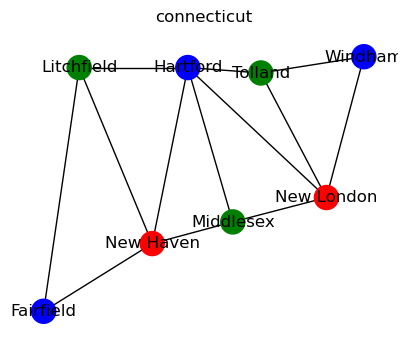

In [30]:
draw_map("connecticut", connecticut, (5,4), connecticut_colors)

Note: the algorithm used the minimum number of colors required for the map, even though four colors were provided as input. The subsquent cell with three colors as input produces the same results.

DEBUG: The variables with the minimum remaining values are ['Fairfield', 'Hartford', 'Litchfield', 'Middlesex', 'New Haven', 'New London', 'Tolland', 'Windham'] with 3 values.
DEBUG: The values ordered by least constraints are ['blue', 'green', 'red'].
ASSIGNING value blue to node Fairfield.
DEBUG: The variables with the minimum remaining values are ['Litchfield', 'New Haven'] with 2 values.
DEBUG: The values ordered by least constraints are ['green', 'red'].
ASSIGNING value green to node Litchfield.
DEBUG: The variables with the minimum remaining values are ['New Haven'] with 1 values.
DEBUG: The values ordered by least constraints are ['red'].
ASSIGNING value red to node New Haven.
DEBUG: The variables with the minimum remaining values are ['Hartford'] with 1 values.
DEBUG: The values ordered by least constraints are ['blue'].
ASSIGNING value blue to node Hartford.
DEBUG: The variables with the minimum remaining values are ['Middlesex'] with 1 values.
DEBUG: The values ordered by lea

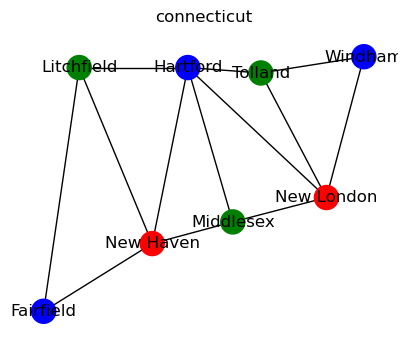

In [31]:
connecticut_colors = color_map( connecticut, ["red", "blue", "green"], trace=True)
if connecticut_colors:
    draw_map("connecticut", connecticut, (5,4), connecticut_colors)

## Color Europe

In [32]:
europe = {
    "nodes":  ["Iceland", "Ireland", "United Kingdom", "Portugal", "Spain",
                 "France", "Belgium", "Netherlands", "Luxembourg", "Germany",
                 "Denmark", "Norway", "Sweden", "Finland", "Estonia",
                 "Latvia", "Lithuania", "Poland", "Czech Republic", "Austria",
                 "Liechtenstein", "Switzerland", "Italy", "Malta", "Greece",
                 "Albania", "Macedonia", "Kosovo", "Montenegro", "Bosnia Herzegovina",
                 "Serbia", "Croatia", "Slovenia", "Hungary", "Slovakia",
                 "Belarus", "Ukraine", "Moldova", "Romania", "Bulgaria",
                 "Cyprus", "Turkey", "Georgia", "Armenia", "Azerbaijan",
                 "Russia" ], 
    "edges": [(0,1), (0,2), (1,2), (2,5), (2,6), (2,7), (2,11), (3,4),
                 (4,5), (4,22), (5,6), (5,8), (5,9), (5,21), (5,22),(6,7),
                 (6,8), (6,9), (7,9), (8,9), (9,10), (9,12), (9,17), (9,18),
                 (9,19), (9,21), (10,11), (10,12), (10,17), (11,12), (11,13), (11,45), 
                 (12,13), (12,14), (12,15), (12,17), (13,14), (13,45), (14,15),
                 (14,45), (15,16), (15,35), (15,45), (16,17), (16,35), (17,18),
                 (17,34), (17,35), (17,36), (18,19), (18,34), (19,20), (19,21), 
                 (19,22), (19,32), (19,33), (19,34), (20,21), (21,22), (22,23),
                 (22,24), (22,25), (22,28), (22,29), (22,31), (22,32), (24,25),
                 (24,26), (24,39), (24,40), (24,41), (25,26), (25,27), (25,28),
                 (26,27), (26,30), (26,39), (27,28), (27,30), (28,29), (28,30),
                 (29,30), (29,31), (30,31), (30,33), (30,38), (30,39), (31,32),
                 (31,33), (32,33), (33,34), (33,36), (33,38), (34,36), (35,36),
                 (35,45), (36,37), (36,38), (36,45), (37,38), (38,39), (39,41),
                 (40,41), (41,42), (41,43), (41,44), (42,43), (42,44), (42,45),
                 (43,44), (44,45)],
    "coordinates": [( 18,147), ( 48, 83), ( 64, 90), ( 47, 28), ( 63, 34),
                   ( 78, 55), ( 82, 74), ( 84, 80), ( 82, 69), (100, 78),
                   ( 94, 97), (110,162), (116,144), (143,149), (140,111),
                   (137,102), (136, 95), (122, 78), (110, 67), (112, 60),
                   ( 98, 59), ( 93, 55), (102, 35), (108, 14), (130, 22),
                   (125, 32), (128, 37), (127, 40), (122, 42), (118, 47),
                   (127, 48), (116, 53), (111, 54), (122, 57), (124, 65),
                   (146, 87), (158, 65), (148, 57), (138, 54), (137, 41),
                   (160, 13), (168, 29), (189, 39), (194, 32), (202, 33),
                   (191,118)]}
print(europe)

{'nodes': ['Iceland', 'Ireland', 'United Kingdom', 'Portugal', 'Spain', 'France', 'Belgium', 'Netherlands', 'Luxembourg', 'Germany', 'Denmark', 'Norway', 'Sweden', 'Finland', 'Estonia', 'Latvia', 'Lithuania', 'Poland', 'Czech Republic', 'Austria', 'Liechtenstein', 'Switzerland', 'Italy', 'Malta', 'Greece', 'Albania', 'Macedonia', 'Kosovo', 'Montenegro', 'Bosnia Herzegovina', 'Serbia', 'Croatia', 'Slovenia', 'Hungary', 'Slovakia', 'Belarus', 'Ukraine', 'Moldova', 'Romania', 'Bulgaria', 'Cyprus', 'Turkey', 'Georgia', 'Armenia', 'Azerbaijan', 'Russia'], 'edges': [(0, 1), (0, 2), (1, 2), (2, 5), (2, 6), (2, 7), (2, 11), (3, 4), (4, 5), (4, 22), (5, 6), (5, 8), (5, 9), (5, 21), (5, 22), (6, 7), (6, 8), (6, 9), (7, 9), (8, 9), (9, 10), (9, 12), (9, 17), (9, 18), (9, 19), (9, 21), (10, 11), (10, 12), (10, 17), (11, 12), (11, 13), (11, 45), (12, 13), (12, 14), (12, 15), (12, 17), (13, 14), (13, 45), (14, 15), (14, 45), (15, 16), (15, 35), (15, 45), (16, 17), (16, 35), (17, 18), (17, 34), (17, 

In [33]:
europe_colors = color_map(europe, ["red", "blue", "green", "yellow"], trace=True)

DEBUG: The variables with the minimum remaining values are ['Albania', 'Armenia', 'Austria', 'Azerbaijan', 'Belarus', 'Belgium', 'Bosnia Herzegovina', 'Bulgaria', 'Croatia', 'Cyprus', 'Czech Republic', 'Denmark', 'Estonia', 'Finland', 'France', 'Georgia', 'Germany', 'Greece', 'Hungary', 'Iceland', 'Ireland', 'Italy', 'Kosovo', 'Latvia', 'Liechtenstein', 'Lithuania', 'Luxembourg', 'Macedonia', 'Malta', 'Moldova', 'Montenegro', 'Netherlands', 'Norway', 'Poland', 'Portugal', 'Romania', 'Russia', 'Serbia', 'Slovakia', 'Slovenia', 'Spain', 'Sweden', 'Switzerland', 'Turkey', 'Ukraine', 'United Kingdom'] with 4 values.
DEBUG: The values ordered by least constraints are ['blue', 'green', 'red', 'yellow'].
ASSIGNING value blue to node Albania.
DEBUG: The variables with the minimum remaining values are ['Greece', 'Italy', 'Kosovo', 'Macedonia', 'Montenegro'] with 3 values.
DEBUG: The values ordered by least constraints are ['green', 'red', 'yellow'].
ASSIGNING value green to node Greece.
DEBUG: 

In [34]:
edges = europe["edges"]
nodes = europe[ "nodes"]
colors = europe_colors
COLOR = 1
for start, end in edges:
    try:
        assert colors[start][COLOR] != colors[end][COLOR]
    except AssertionError:
        print(f"{nodes[start]} and {nodes[end]} are adjacent but have the same color.")

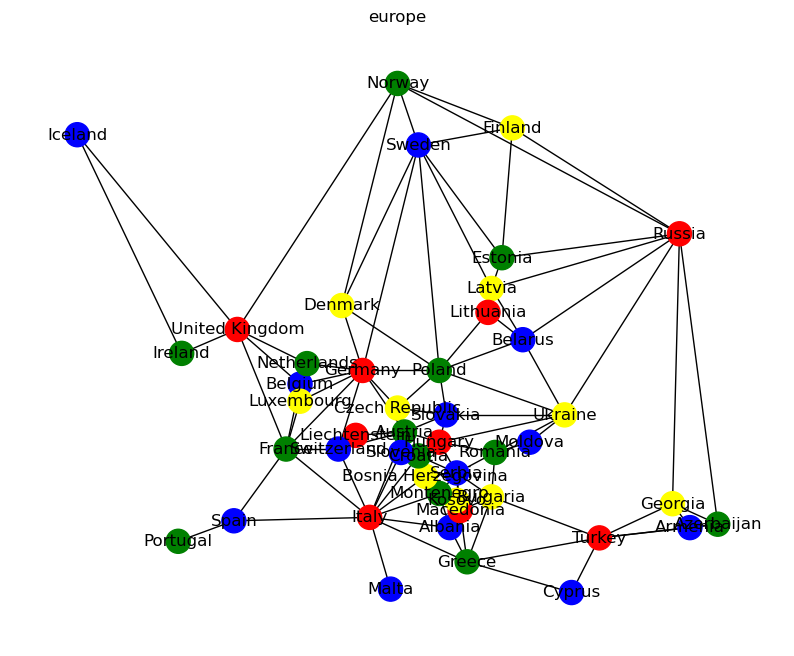

In [35]:
draw_map("europe", europe, (10,8), europe_colors)

The test above required four colors for Europe. The subsequent cells demonstrates that Europe cannot be colored with 3 colors. 

In [36]:
europe_colors = color_map(europe, ["red", "blue", "green"], trace=True)
if europe_colors:
     draw_map("europe", europe, (10,8), europe_colors)

DEBUG: The variables with the minimum remaining values are ['Albania', 'Armenia', 'Austria', 'Azerbaijan', 'Belarus', 'Belgium', 'Bosnia Herzegovina', 'Bulgaria', 'Croatia', 'Cyprus', 'Czech Republic', 'Denmark', 'Estonia', 'Finland', 'France', 'Georgia', 'Germany', 'Greece', 'Hungary', 'Iceland', 'Ireland', 'Italy', 'Kosovo', 'Latvia', 'Liechtenstein', 'Lithuania', 'Luxembourg', 'Macedonia', 'Malta', 'Moldova', 'Montenegro', 'Netherlands', 'Norway', 'Poland', 'Portugal', 'Romania', 'Russia', 'Serbia', 'Slovakia', 'Slovenia', 'Spain', 'Sweden', 'Switzerland', 'Turkey', 'Ukraine', 'United Kingdom'] with 3 values.
DEBUG: The values ordered by least constraints are ['blue', 'green', 'red'].
ASSIGNING value blue to node Albania.
DEBUG: The variables with the minimum remaining values are ['Greece', 'Italy', 'Kosovo', 'Macedonia', 'Montenegro'] with 2 values.
DEBUG: The values ordered by least constraints are ['green', 'red'].
ASSIGNING value green to node Greece.
DEBUG: The variables with t